Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

In [2]:
# Load dataset
ready_data = pd.read_csv('./import/dataset_prepared.csv')

# 2. Split the dataset into features and target.

In [3]:
X = ready_data.drop('Class', axis=1)
y = ready_data['Class']

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [5]:
random_states = [0, 25, 42]

## 3. Random Forest Classfier

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import shap


feature_names = ["Age", "ОССН KiLLip", "HBR (b)", "Systolic AP(b)", "Creatine in blood", "EF Percentage", "White blood cells count", "Glucose"]

feature_importances = pd.DataFrame(index=feature_names)
shap_values_list = []
test_proba_dic = {}

for random_state in random_states:

    # Split the data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    # sm = SMOTE(random_state=0)
    # X_train, y_train = sm.fit_resample(X_train, y_train)

    # Define model
    model = RandomForestClassifier(random_state=random_state, class_weight="balanced")
    
    # Define hyperparameters for grid search
    hyperparameter_grid = {
        'n_estimators': [100, 200, 250, 300], 
        'max_depth': [None, 2, 5, 10, 15, 25], 
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
        }


    # Define grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=skf,
                           scoring='f1_macro')
    
    # Execute grid search
    grid_cv.fit(X_train, y_train)
    
    # Display best parameters
    display(grid_cv.best_params_)
    
    # Retrain the model with the best parameters
    model = RandomForestClassifier(random_state=random_state, 
                                   n_estimators=grid_cv.best_params_['n_estimators'], 
                                   max_depth=grid_cv.best_params_['max_depth'], 
                                   min_samples_split=grid_cv.best_params_['min_samples_split'],
                                   max_features=grid_cv.best_estimator_.max_features,
                                   class_weight="balanced",
                                   n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    #test_proba_dic[f"{random_state=}"] = [y_test, y_pred_proba]
    
    # Predict classes
    y_pred = model.predict(X_test)

    # Print ROC-AUC, confusion matrix, and classification report
    print(f"========== {random_state=} ==========")
    print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba))
    print('Classification report:\n', classification_report(y_test, y_pred))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test, check_additivity=False)

    shap_values_list.append(shap_values[0])
    feature_importances[random_state] = model.feature_importances_
    feature_importances[str(random_state)+"_shap"] = np.mean(np.abs(shap_values[1]), axis=0)

# Calculate mean feature importances and SHAP values
feature_importances['mean_importance'] = feature_importances[random_states].mean(axis=1)
feature_importances['mean_shap'] = feature_importances[[str(state) + "_shap" for state in random_states]].mean(axis=1)

{'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

========== random_state=0 ==========
ROC-AUC: 0.873899217221135
Confusion matrix:
 [[575   9]
 [ 20   1]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       584
           1       0.10      0.05      0.06        21

    accuracy                           0.95       605
   macro avg       0.53      0.52      0.52       605
weighted avg       0.94      0.95      0.94       605



{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

========== random_state=25 ==========
ROC-AUC: 0.8668460534898891
Confusion matrix:
 [[556  28]
 [ 11  10]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       584
           1       0.26      0.48      0.34        21

    accuracy                           0.94       605
   macro avg       0.62      0.71      0.65       605
weighted avg       0.96      0.94      0.94       605



{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

========== random_state=42 ==========
ROC-AUC: 0.9170743639921721
Confusion matrix:
 [[544  40]
 [  6  15]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       584
           1       0.27      0.71      0.39        21

    accuracy                           0.92       605
   macro avg       0.63      0.82      0.68       605
weighted avg       0.96      0.92      0.94       605



In [14]:
feature_importances

,0,0_shap,25,25_shap,42,42_shap,mean_importance,mean_shap
Age,0.084848,0.009625,0.064985,0.018521,0.069416,0.015383,0.073083,0.014510
ОССН KiLLip,0.081531,0.016380,0.088057,0.032660,0.115417,0.033965,0.095002,0.027668
HBR (b),0.156493,0.021628,0.136769,0.026918,0.137116,0.037769,0.143459,0.028772
Systolic AP(b),0.084441,0.014862,0.055804,0.010050,0.066396,0.012982,0.068880,0.012631
Creatine in blood,0.132828,0.016441,0.153033,0.021057,0.163330,0.030039,0.149730,0.022512
EF Percentage,0.201662,0.029664,0.242188,0.074932,0.209764,0.068496,0.217871,0.057697
White blood cells count,0.109617,0.011767,0.090532,0.032544,0.111118,0.032903,0.103756,0.025738
Glucose,0.148579,0.018526,0.168632,0.040379,0.127443,0.036919,0.148218,0.031941


In [15]:
import matplotlib.pyplot as plt

def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='blue', height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color='orange', height=barWidth, edgecolor='grey', label=label2)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  


    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

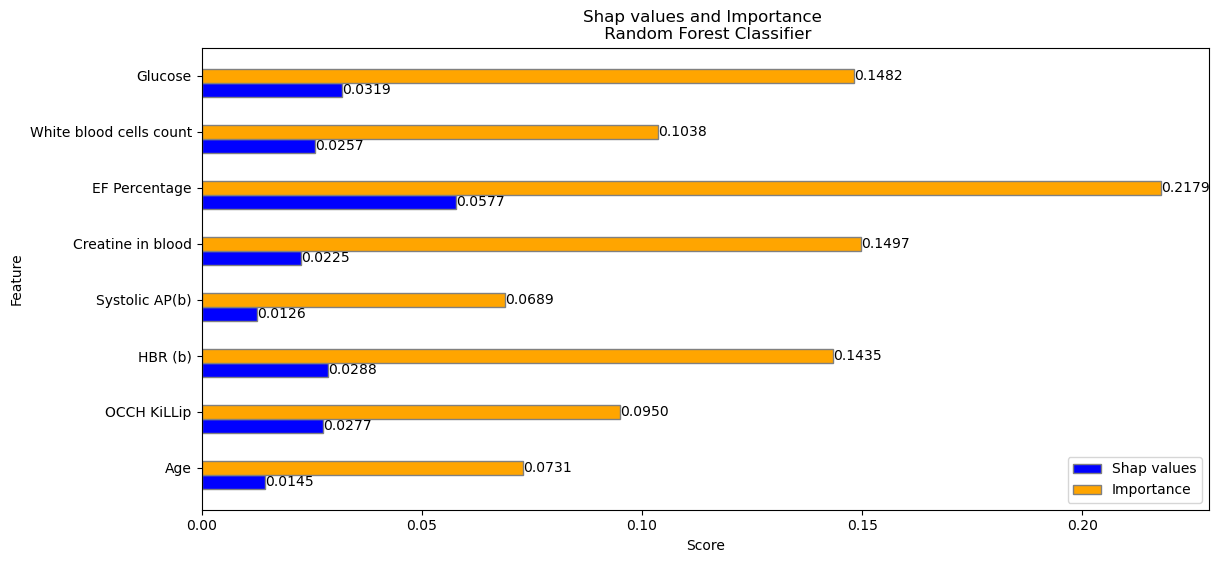

In [16]:
plot_weights(feature_importances, 
             column1='mean_shap', 
             column2='mean_importance', 
             label1='Shap values', 
             label2='Importance', 
             title='Shap values and Importance \n Random Forest Classifier',
             num_digits=4)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


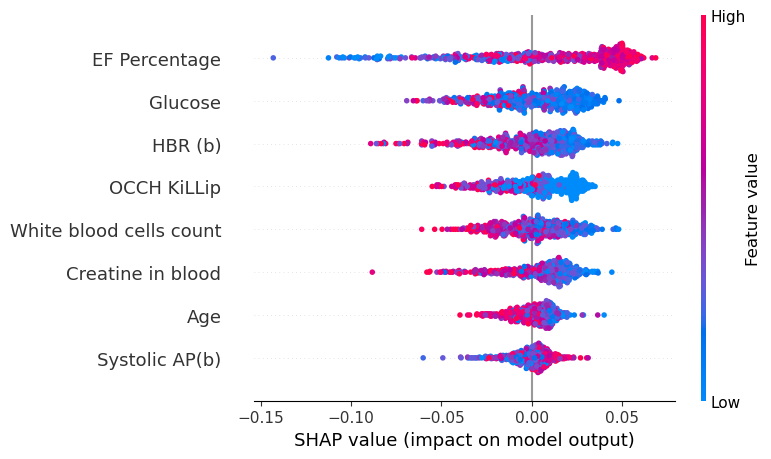

In [17]:
mean_shap_values = np.mean(shap_values_list, axis=0)
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names)